# Shoulder Peak Finder

This function accepts a list of y values, and then calculates the first and second order differential. If the first order differential is positive, then the shoulder will be present when the second order differential is positive as well. If the first order differential is negative, then the shoulder will be present when the second order differential is negative as well. 

A simple case of this is shown in the first example. A more complex case is shown in the second example

In [210]:
import numpy as np
import pandas as pd
from scipy import signal

def peak_shoulder_index(y, frame=5, order=3, returnInflection=False, returnPeak=True, returnY=False, min_dist = 1):
    '''Determines the locations of peaks and inflection points of a signal.

     Iteratively performs a polynomial fitting in the data to detect its
     baseline. At every iteration, the fitting weights on the regions with
     peaks are reduced to identify the baseline only.
     Parameters
     ----------
     y : ndarray
         Data to detect the baseline.
     deg : int
         Degree of the polynomial that will estimate the data baseline. A low
         degree may fail to detect all the baseline present, while a high
         degree may make the data too oscillatory, especially at the edges.
     max_it : int
         Maximum number of iterations to perform.
     tol : float
         Tolerance to use when comparing the difference between the current
         fit coefficient and the ones from the last iteration. The iteration
         procedure will stop when the difference between them is lower than
         *tol*.
     Returns
     -------
     ndarray
         Array with the baseline amplitude for every original point in *y*'''

    yfilter = signal.savgol_filter(y, frame, order)
    
    inflection_points_index, peaks_index = index_return(yfilter, min_dist = min_dist)

    if returnY == False:
        if returnInflection == True and returnPeak == True:
            return peaks_index, inflection_points_index
        elif returnInflection == False and returnPeak == True:
            return peaks_index
        else:
            return inflection_points_index

    else:
        if returnInflection == True and returnPeak == True:
            return peaks_index, inflection_points_index, yfilter
        elif returnInflection == False and returnPeak == True:
            return peaks_index, yfilter
        else:
            return inflection_points_index, yfilter

In [232]:
def index_return(y_list, min_dist = 1):
    '''
Input a y list, and peak_shoulder_finder will return a list of indexes
for all inflection points and all peaks

inflection_points_index, peaks_index = peak_shoulder_finder(y_list)

'''

    # calculate the first and second derivatives of the y list
    dy = np.diff(y_list)
    dydy = np.diff(dy)

    # convert values to list and dataframe
    y_list = y_list[2:].tolist()
    dy_list = dy[1:].tolist()
    dydy_list = dydy.tolist()
    all_lists = pd.DataFrame(
        {'y': y_list,
         'dy': dy_list,
         'dydy': dydy_list})

    inflection_points_index = []
    peaks_index = []
    differences_first_list = []
    differences_second_list = []

    for i in range(0, len(all_lists)-1):

        #calculate the directions of the first and second derivatives
        #if the first and second derivate pass through zero from positive to
        #negative or vice versa
        first_derivative = (all_lists.iloc[i]['dy']>=0
                                >= all_lists.iloc[i+1]['dy'])
        first_derivative_positive = all_lists.iloc[i]['dy']>=0
        first_derivative_negative = all_lists.iloc[i]['dy']<0
        second_derivative_positive = (all_lists.iloc[i]['dydy']<=0
                                        <=all_lists.iloc[i+1]['dydy'])
        second_derivative_negative = (all_lists.iloc[i]['dydy']>=0
                                        >=all_lists.iloc[i+1]['dydy'])

        #add the desired first and second derivatives to a list and return
        if first_derivative:
            peaks_index.append(i)

        if first_derivative_positive and second_derivative_positive:
            inflection_points_index.append(i)
            difference_first = all_lists.iloc[i]['dy']
            differences_first_list.append(difference_first)
            difference_second = all_lists.iloc[i]['dydy']
            differences_second_list.append(difference_second)
            #difference_second = all_lists.iloc[i]['dydy'] - all_lists.iloc[i-1]['dydy']
            #differences_second_list.append(difference_second)

        if first_derivative_negative and second_derivative_negative:
            inflection_points_index.append(i)
            difference_first = all_lists.iloc[i]['dy']
            differences_first_list.append(difference_first)
            difference_second = all_lists.iloc[i]['dydy']
            differences_second_list.append(difference_second)
            #difference_second = all_lists.iloc[i]['dydy'] - all_lists.iloc[i-1]['dydy']
            #differences_second_list.append(difference_second)

    inflection_points = pd.DataFrame(
        {'indexes': inflection_points_index,
         'differences first': differences_first_list,
         'differences second': differences_second_list
        })

    #inflection_points_index = [int(i) for i in np.abs(inflection_points).sort_values('differences', ascending = True).reset_index(drop = True).loc[:number_of_inflections-1]['indexes'].tolist()]

    inflection_points['Bool'] = 1
    
    print inflection_points
    
    for i in range(0,(len(inflection_points)-1)):
        if (inflection_points['indexes'].iloc[i+1] - inflection_points['indexes'].iloc[i]) < min_dist:
            if inflection_points['differences first'].iloc[i+1] > inflection_points['differences first'].iloc[i]:
                inflection_points['Bool'].iloc[i+1] = 0

    print inflection_points
    
    inflection_points_index = inflection_points[inflection_points['Bool']==1]['indexes'].values

    #inflection_points_index = inflection_points[np.abs(inflection_points['differences first'])<threshold]['indexes'].values

    return inflection_points_index, peaks_index

### Example 1: Using an artifically created dataset

   differences first  differences second  indexes  Bool
0           0.030338           -0.001237       31     1
1          -0.232309            0.001661       85     1


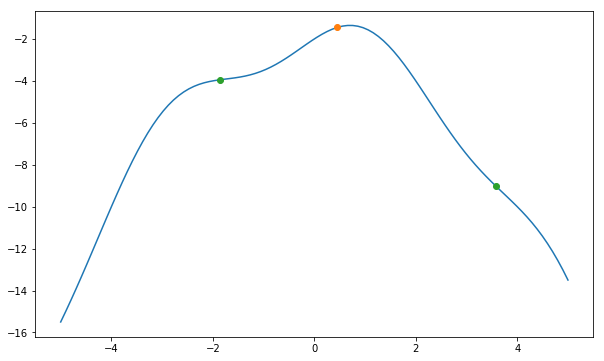

In [217]:
# using an artificial dataset
pts=100 
x=np.linspace(-5,5,num=pts)
yactual_1 = np.sin(x * 0.5*np.pi)
yactual_2 = -(0.5 * (x-2))**2
yactual_3 = -(0.5* (x+2))**2
yactual_4 = yactual_1 + yactual_2 + yactual_3

inflection_points_index_1, peaks_index_1 = index_return(yactual_4, min_dist = 3)

pyplot.figure(figsize=(10,6))
pyplot.plot(x, yactual_4)
pyplot.plot(x[peaks_index_1], yactual_4[peaks_index_1], 'o')
pyplot.plot(x[inflection_points_index_1], yactual_4[inflection_points_index_1], 'o')

### Example 2: Using a real, noisy, dataset

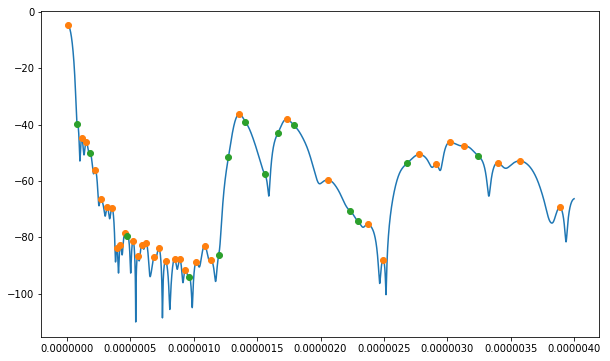

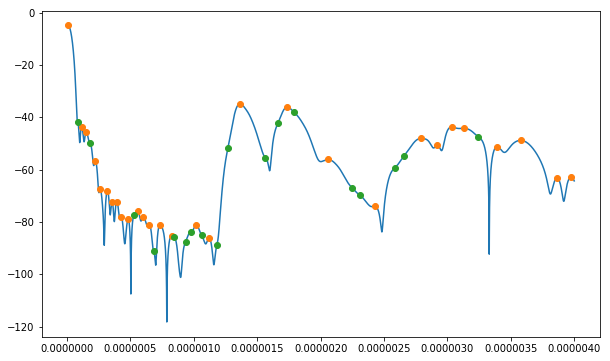

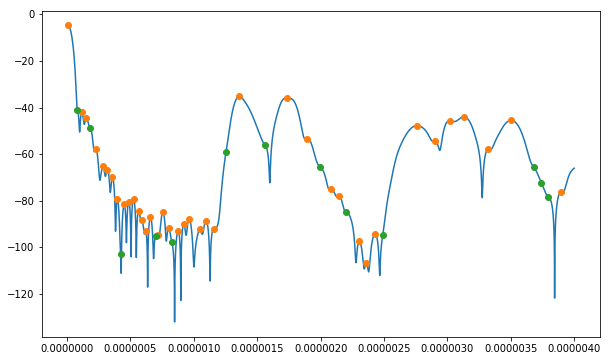

In [209]:
# file 1

file_1 = pd.read_csv('../JaganData/3C4-S11td-072817.dat', names = ['x', 'y' , 'bad'], skiprows = 3)
file_1 = file_1[['x', 'y']]
inflection_points_index_1, peaks_index_1 = index_return(file_1['y'], min_dist = 5)

pyplot.figure(figsize=(10,6))
pyplot.plot(file_1['x'], file_1['y'])
pyplot.plot(file_1['x'][peaks_index_1], file_1['y'][peaks_index_1], 'o')
pyplot.plot(file_1['x'][inflection_points_index_1], file_1['y'][inflection_points_index_1], 'o')

# file 2

file_2 = pd.read_csv('../JaganData/4C4-S11td-072817.dat', names = ['x', 'y' , 'bad'], skiprows = 3)
file_2 = file_2[['x', 'y']]
inflection_points_index_2, peaks_index_2 = index_return(file_2['y'], min_dist = 5)

pyplot.figure(figsize=(10,6))
pyplot.plot(file_2['x'], file_2['y'])
pyplot.plot(file_2['x'][peaks_index_2], file_2['y'][peaks_index_2], 'o')
pyplot.plot(file_2['x'][inflection_points_index_2], file_2['y'][inflection_points_index_2], 'o')

# file 3

file_3 = pd.read_csv('../JaganData/5C4-S11td-072817.dat', names = ['x', 'y' , 'bad'], skiprows = 3)
file_3 = file_3[['x', 'y']]
inflection_points_index_3, peaks_index_3 = index_return(file_3['y'], min_dist = 5)

pyplot.figure(figsize=(10,6))
pyplot.plot(file_3['x'], file_3['y'])
pyplot.plot(file_3['x'][peaks_index_3], file_3['y'][peaks_index_3], 'o')
pyplot.plot(file_3['x'][inflection_points_index_3], file_3['y'][inflection_points_index_3], 'o')

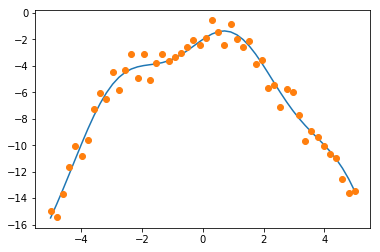

In [230]:
import matplotlib.pyplot as plt

pts=50 
noisescale=.05

x=np.linspace(-5,5,num=pts)

yactual_1 = np.sin(x * 0.5*np.pi)
yactual_2 = -(0.5 * (x-2))**2
yactual_3 = -(0.5* (x+2))**2
yactual = yactual_1 + yactual_2 + yactual_3
#np.random.seed(123) for reproducible 
#add noise scaled to 25% of range to data
yrand=yactual+noisescale*(yactual.max()-yactual.min())*np.random.normal(size=pts)

plt.plot(x, yactual)
plt.plot(x, yrand, 'o')

   differences first  differences second  indexes  Bool
0           0.063181           -0.089360       14     1
1           0.217644           -0.009068       17     1
2           0.183181           -0.043387       19     1
3           0.250150           -0.077869       22     1
4           0.028814           -0.107183       25     1
5          -0.348900            0.001476       30     1
6          -0.573042            0.094805       34     1
7          -0.520223            0.149511       37     1
8          -0.572644            0.068747       39     1
   differences first  differences second  indexes  Bool
0           0.063181           -0.089360       14     1
1           0.217644           -0.009068       17     0
2           0.183181           -0.043387       19     1
3           0.250150           -0.077869       22     0
4           0.028814           -0.107183       25     1
5          -0.348900            0.001476       30     0
6          -0.573042            0.094805       3

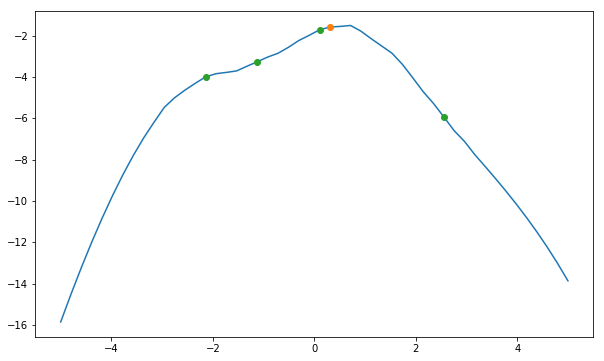

In [233]:
peaks_index_1, inflection_points_index_1, yfilt = peak_shoulder_index(yrand, frame=19, order=3, returnInflection=True, returnPeak=True, returnY=True, min_dist = 10)

pyplot.figure(figsize=(10,6))
pyplot.plot(x, yfilt)
pyplot.plot(x[peaks_index_1], yfilt[peaks_index_1], 'o')
pyplot.plot(x[inflection_points_index_1], yfilt[inflection_points_index_1], 'o')